# Declare U-Net CNN

Note, I'm running on CUDA device - multiple GPUs and taking advantage of it. You might want to tweak some things if this is not the case for you. 

The following is based on code in [Kaggle 1](https://www.kaggle.com/code/taufiqkhan116/brain-tumor-segmentation) and [Kaggle 2](https://www.kaggle.com/code/krn0209/unet2d) for BraTS competition.

Data downloaded from the same competition, link is [here](https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1/data)

## Load Libraries and Define Constants

In [1]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from IPython.display import Image, display
from torchvision import transforms
from PIL import Image as PILImage
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nibabel as nib
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import tempfile
import tarfile
import imageio
import shutil
import torch
import os

In [36]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#in_path = './BraTS2021_Training_Data.tar'
data_dir = './BraTS2021_Training_Data'

checkpoint_path = './model_weights/deep_last_checkpoint_t1.pth'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
best_model_path = './model_weights/deep_best_model_t1.pth'
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
validation_loss_path = "./results/deep_validation_loss.txt"
os.makedirs(os.path.dirname(validation_loss_path), exist_ok=True)
training_loss_path = "./results/deep_training_loss.txt"
os.makedirs(os.path.dirname(training_loss_path), exist_ok=True)

EPOCHS = 30
LEARNING_RATE = 0.001
EARLY_STOP = 5
WEIGHT_DECAY = 1e-5

# Parameters
batch_size = 12
val_split = 0.2  # Proportion of the dataset to include in the validation set
test_split = 0.1  # Proportion of the dataset to include in the test set
shuffle_dataset = True  # Shuffle dataset before splitting
random_seed = 42  # Random seed for reproducibility

Using device: cuda


## Visualize Data Sample(s)

In [3]:
def uncompress_tar(tar_file_path, uncompressed_dir):
    if not os.path.isfile(tar_file_path):
        raise FileNotFoundError(f"Tar file not found: {tar_file_path}")

    if not os.path.exists(uncompressed_dir):
        os.makedirs(uncompressed_dir)

    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=uncompressed_dir)

    print(f"Uncompressed {tar_file_path} to {uncompressed_dir}")
    
def load_nifti_image(file_path):
    """Load a NIfTI file."""
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

def create_gif_from_slices(img_data, axis=2, duration=0.1, resize_to=None):
    """
    Create a GIF from slices of a 3D image and display it.
    
    Parameters:
    img_data (numpy.ndarray): 3D image data.
    axis (int): Axis along which to slice the 3D image.
    duration (float): Duration between frames in the GIF.
    """
    # Get the number of slices along the specified axis
    num_slices = img_data.shape[axis]
    
    # Create a temporary directory to store the slice images
    temp_dir = tempfile.mkdtemp()
    
    # Create a list to store the filenames of the slice images
    slice_images = []
    
    for i in range(num_slices):
        plt.figure()
        if axis == 0:
            plt.imshow(img_data[i, :, :], cmap='gray')
        elif axis == 1:
            plt.imshow(img_data[:, i, :], cmap='gray')
        elif axis == 2:
            plt.imshow(img_data[:, :, i], cmap='gray')
        else:
            raise ValueError("Axis must be 0, 1, or 2.")
        plt.axis('off')
        
        # Save the slice image
        slice_filename = os.path.join(temp_dir, f"slice_{i:03d}.png")
        plt.savefig(slice_filename, bbox_inches='tight', pad_inches=0)
        plt.close()
        
        # Append the filename to the list
        slice_images.append(slice_filename)
    
    # Create the GIF
    gif_path = os.path.join(temp_dir, "output.gif")
    with imageio.get_writer(gif_path, mode='I', duration=duration, loop=0) as writer:
        for slice_filename in slice_images:
            image = imageio.v2.imread(slice_filename)
            if resize_to:
                image = PILImage.fromarray(image).resize(resize_to, PILImage.Resampling.LANCZOS)
                image = np.array(image)
            writer.append_data(image)
    
    # Display the GIF
    display(Image(filename=gif_path))
    
    # Clean up temporary slice images
    shutil.rmtree(temp_dir)

In [5]:
#uncompress_tar(in_path, data_dir)

(240, 240, 155)


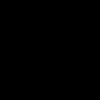

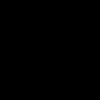

In [5]:
path = 'BraTS2021_Training_Data/BraTS2021_00100/BraTS2021_00100'
suffixes = ['_t1.nii.gz', '_seg.nii.gz']

nifti_t1_path = path + suffixes[0]
img_t1 = load_nifti_image(nifti_t1_path)
print(img_t1.shape)
create_gif_from_slices(img_t1, axis=2, duration=0.1, resize_to=(100, 100))

nifti_seg_path = path + suffixes[1]
img_seg = load_nifti_image(nifti_seg_path)
create_gif_from_slices(img_seg, axis=2, duration=0.1, resize_to=(100, 100))

(240, 240, 155)


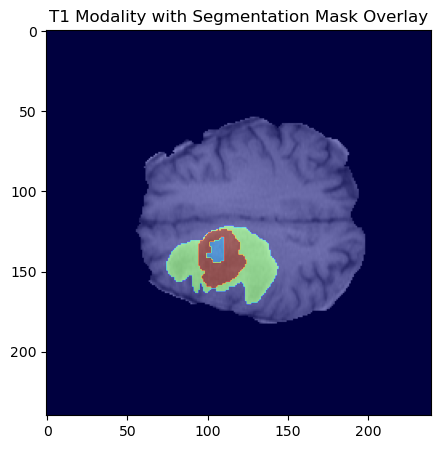

In [6]:
# Visualize one sample - T1ce Modality with overlaid segmentation mask
slice = 100
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
print(img_t1.shape)
ax.imshow(img_t1[:,:,slice], cmap='gray')
ax.imshow(img_seg[:,:,slice], cmap='jet', alpha=0.5)  # alpha controls the transparency

ax.set_title('T1 Modality with Segmentation Mask Overlay')
#ax.axis('off')

plt.show()

## Dataset loading

For now, use T1 data only, but this is completely arbitary

In [37]:
class BRATST1Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.samples = [
            sample for sample in os.listdir(data_dir)
            if sample.startswith('BraTS') and 
            os.path.exists(os.path.join(data_dir, sample, f"{sample}_t1.nii.gz")) and 
            os.path.exists(os.path.join(data_dir, sample, f"{sample}_seg.nii.gz"))
        ]
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample_name = self.samples[idx]
        sample_dir = os.path.join(self.data_dir, sample_name)
        
        # Load MRI modalities and segmentation mask
        t1_path = os.path.join(sample_dir, f"{sample_name}_t1.nii.gz")
        seg_path = os.path.join(sample_dir, f"{sample_name}_seg.nii.gz")

        # Load and preprocess the T1 data
        h, w = 128, 128    
        t1_data = nib.load(t1_path).get_fdata()
        t1_data = np.resize(t1_data, (h, w, 155))
        
        # Load and preprocess the segmentation data
        seg_data = nib.load(seg_path).get_fdata()
        seg_data = np.resize(seg_data, (h, w, 155))
        seg_data = np.transpose(seg_data, (2, 0, 1))
        
        # Convert numpy arrays to PyTorch tensors
        x = np.transpose(t1_data, (2, 0, 1))
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(seg_data, dtype=torch.float32)
        
        return x, y


## Use the T1 data only for segmentation

Segmentation specified by associated "\_seg" files

In [38]:
# Load the dataset
dataset = BRATST1Dataset(data_dir)

# Determine the lengths of training, validation, and test sets
dataset_size = len(dataset)
test_size = int(test_split * dataset_size)
val_size = int(val_split * (dataset_size - test_size))
train_size = dataset_size - val_size - test_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed)
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Optionally print the sizes of each dataset to verify
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 887
Validation set size: 221
Test set size: 123


Using device: cuda


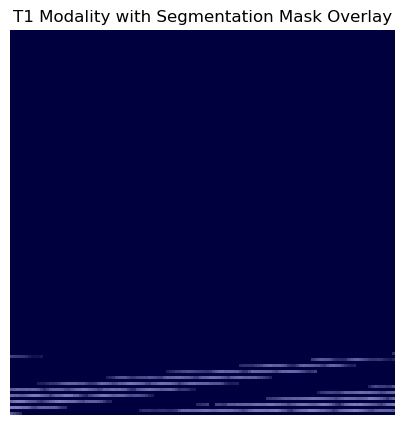

In [39]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load one batch from the validation dataloader
data_iter = iter(test_dataloader)
t1_batch, seg_batch = next(data_iter)

# Select the first sample in the batch
t1_sample = t1_batch[2]  # Shape: (155, H, W)
seg_sample = seg_batch[2]  # Shape: (155, H, W)

# Choose the slice to visualize
slice_idx = 100  # Adjust this to view different slices
t1_slice = t1_sample[slice_idx].cpu().numpy()
seg_slice = seg_sample[slice_idx].cpu().numpy()

# Plot the slice with overlay
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(t1_slice, cmap='gray')
ax.imshow(seg_slice, cmap='jet', alpha=0.5)  # Overlay with segmentation mask

ax.set_title('T1 Modality with Segmentation Mask Overlay')
ax.axis('off')
plt.show()


## Define 2D Convolutional Neural Network model

In [40]:
class UNet2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet2D, self).__init__()

        self.dropout = nn.Dropout(0.2)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        self.bottleneck = self.conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # Replace Landon's code with some variable abstraction
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        #print(f"X shape: {x.shape}")
        x = self.dropout(x)
        enc1 = self.encoder1(x)
        #print(f"Enc1 shape: {enc1.shape}")
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        #print(f"Enc2 shape: {enc2.shape}")
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        #print(f"Enc3 shape: {enc3.shape}")
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        #print(f"Enc4 shape: {enc1.shape}")

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        #print(f"Bottleneck shape: {bottleneck.shape}")

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        #print(f"Dec4 shape: {dec4.shape}")
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        #print(f"Dec3 shape: {dec3.shape}")
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        #print(f"Dec2 shape: {dec2.shape}")
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        #print(f"Dec1 shape: {dec1.shape}")
        
        output = self.final_conv(dec1)
        #print(f"Output shape: {output.shape}")
        return output

In [41]:
## Model Summary
model = UNet2D(155, 155)
#model = nn.DataParallel(model)
model = model.to(device) # Ensure the model is on GPU

## Training

### Setup

In [42]:
class DiceLoss(nn.Module):
    # Use DiceLoss as metric
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = DiceLoss()

# Early stopping parameters
early_stopping_patience = EARLY_STOP
best_val_loss = float('inf')
patience_counter = 0

# Number of epochs
num_epochs = EPOCHS

### Train

Note that I'm training on a subset of data, about 300 samples (see above), so losses might be a bit wild

In [44]:
# Load checkpoint if it exists
start_epoch = 0
best_val_loss = float('inf')
#checkpoint_path = "home/lmattin1/HonorsThesis/model_weights/best_model_t1.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {start_epoch}")

/tmp/ipykernel_1520273/345691724.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


NameError: name 'scaler' is not defined

In [110]:
scaler = GradScaler()
training_losses = []
validation_losses = []
patience_counter = 0

with open(training_loss_path, "a") as f:
    f.write("starting new training\n")
with open(validation_loss_path, "a") as f:
    f.write("starting new training\n")

for epoch in range(start_epoch, num_epochs):
    print('Starting Epoch {}'.format(epoch+1))
    model.train()
    train_loss = 0.0
    train_loader = tqdm(train_dataloader, desc="Training", leave=False)
    for vimage, mask in train_loader:
        if vimage is None or mask is None:
            continue 
        vimage, mask = vimage.to(device).float(), mask.to(device).float()
        optimizer.zero_grad()
        
        predicted_mask = model(vimage)
        loss = loss_fn(predicted_mask, mask)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
            
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    with open(training_loss_path, "a") as f:
        f.write(f"{avg_train_loss}\n")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        validation_loader = tqdm(val_dataloader, desc="Validation", leave=False)
        for vimage, mask in validation_loader:
            vimage, mask = vimage.to(device).float(), mask.to(device).float()
                
            predicted_mask = model(vimage)
            loss = loss_fn(predicted_mask, mask)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    validation_losses.append(val_loss)
    with open(validation_loss_path, "a") as g:
        g.write(f"{val_loss}\n")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {val_loss}")

    # Save the checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_loss': best_val_loss,
    }
    torch.save(checkpoint, checkpoint_path)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


/tmp/ipykernel_1630960/2428343002.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting Epoch 2


Epoch 2/30, Training Loss: 0.5685333649854403, Validation Loss: 0.5089521408081055
Starting Epoch 3


Epoch 3/30, Training Loss: 0.46737938636058085, Validation Loss: 0.446273524510233
Starting Epoch 4


Epoch 4/30, Training Loss: 0.44269976905874303, Validation Loss: 0.4334274875490289
Starting Epoch 5


Epoch 5/30, Training Loss: 0.43806305769327525, Validation Loss: 0.4334274875490289
Starting Epoch 6


Epoch 6/30, Training Loss: 0.4380280109676155, Validation Loss: 0.4334274875490289
Starting Epoch 7


Epoch 7/30, Training Loss: 0.4380088432415112, Validation Loss: 0.43342749068611547
Starting Epoch 8


Epoch 8/30, Training Loss: 0.43804940259134445, Validation Loss: 0.4334275032344617
Starting Epoch 9


Epoch 9/30, Training Loss: 0.4380014981772449, Validation Loss: 0.43342760675831843
Early stopping at epoch 9


## Analyze the results - plot and numerical

Results are not super unusual. It's a big architecture and I'm using only a small (very small relative) bit of data to test, so some "spikiness" is not weird. 

Evaluation Metrics for Segmentation: Dice Coefficient and IoU Score - Our evaluation metrics absolutely suck here. I am almost certain I am computing them incorrectly relative to the objective function, will fix later. 

In [17]:
# Calculate the number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Assuming 4 bytes per parameter (float32)
model_size_bytes = total_params * 4

# Print the model size in bytes and human-readable format
print(f"Model size: {model_size_bytes} bytes")
print(f"Model size (human-readable): {model_size_bytes / (1024**3):.2f} GB")

Model size: 124517228 bytes
Model size (human-readable): 0.12 GB


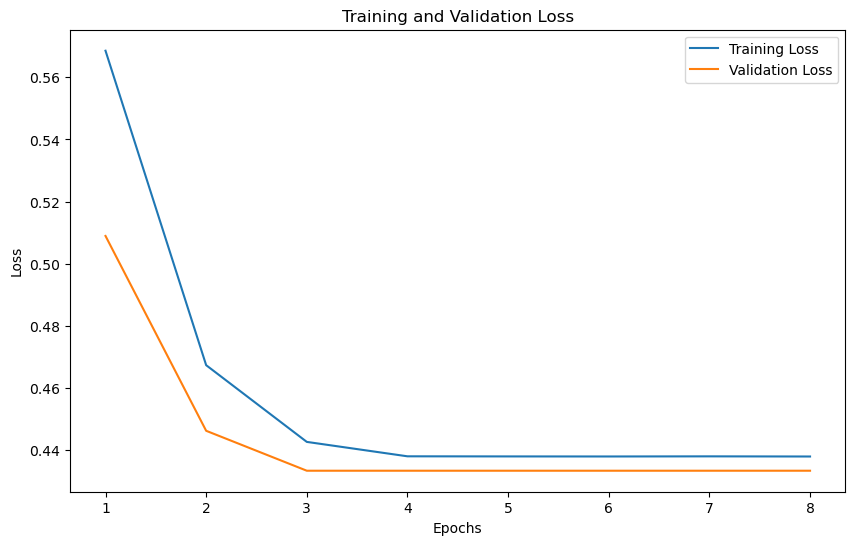

In [114]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 1), training_losses, label='Training Loss')
plt.plot(range(1, epoch + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("/home/lmattin1/HonorsThesis/unet_cnnLoss.png")
plt.show()

In [45]:
def dice_coefficient(predicted, target):
    """
    Compute the Dice Coefficient.
    :param predicted: the logits or the prediction from the model.
    :param target: the target mask.
    :return: the Dice coefficient.
    """
    smooth = 1e-5 
    #added .float() and removed thresholding
    predicted = torch.sigmoid(predicted).float()
    #predicted = (predicted > 0.5).float() 
    
    intersection = (predicted * target.float()).sum()
    dice = (2. * intersection + smooth) / (predicted.sum() + target.sum() + smooth)
    
    return dice

def iou_score(predicted, target):
    """
    Compute the Intersection over Union (IoU) score.
    :param predicted: the logits or the prediction from the model.
    :param target: the target mask.
    :return: the IoU score.
    """
    predicted = torch.sigmoid(predicted)  
    predicted = (predicted > 0.5).float()  
    
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum() - intersection
    
    iou = (intersection + 1.0) / (union + 1.0)  
    return iou
    
# Set the model to evaluation mode
model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, true_masks in test_dataloader:
        images = images.to(device).float()  
        true_masks = true_masks.to(device).float() 
        preds = model(images)
        for pred, true_mask in zip(preds, true_masks):
            #pred = torch.sigmoid(pred).float() 
            #pred = (pred > 0.5).float() 
            
            dice_scores.append(dice_coefficient(pred, true_mask).item())
            iou_scores.append(iou_score(pred, true_mask).item())

print(f"Average Dice Coefficient: {(sum(dice_scores) / len(dice_scores))}")
print(f"Average IoU Score: {sum(iou_scores) / len(iou_scores)}")

Average Dice Coefficient: 0.011155125079745335
Average IoU Score: 0.005785593355214839


Input batch shape: torch.Size([12, 155, 128, 128])
Predictions shape: torch.Size([12, 155, 128, 128])


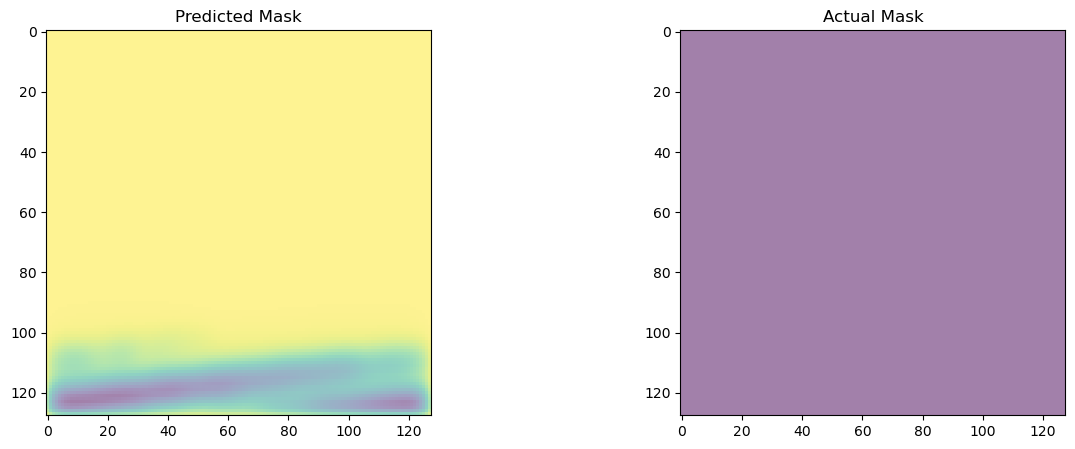

In [54]:
# Disable gradient calculation for evaluation
with torch.no_grad():
    data_iter = iter(train_dataloader)
    t1_batch, seg_batch = next(data_iter)
    
    # Move input batch and segmentation batch to the device
    t1_batch = t1_batch.to(device)
    seg_batch = seg_batch.to(device)
    
    # Print shape of the input tensor
    print("Input batch shape:", t1_batch.shape)
    
    # Get model predictions
    preds = model(t1_batch)  # Add batch dimension to the first sample for compatibility
    print("Predictions shape:", preds.shape)
    
    # Move predictions to CPU for visualization if needed
    preds = preds.cpu()
    
    # Plot a sample prediction for the 100th slice (change slice index as needed)
    batch_idx = 9
    slice_idx = 0
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    #axs[0].imshow(t1_batch[batch_idx,slice_idx,:,:].cpu().detach(), cmap="gray")
    axs[0].imshow(preds[batch_idx, slice_idx, :, :].detach().numpy(), cmap="viridis", alpha=0.5)
    axs[0].set_title('Predicted Mask')
    #axs[1].imshow(t1_batch[batch_idx,slice_idx,:,:].cpu().detach(), cmap="gray")
    axs[1].imshow(seg_batch[batch_idx,slice_idx,:,:].cpu().detach(), cmap="viridis", alpha=0.5)
    axs[1].set_title("Actual Mask")
    plt.show()